## Importing Required Libraries

In [515]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale, StandardScaler
import sklearn.metrics as mt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [516]:
data = pd.read_csv("insurance.csv")
df = data.copy()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


In [517]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Exploratory Data Analysis

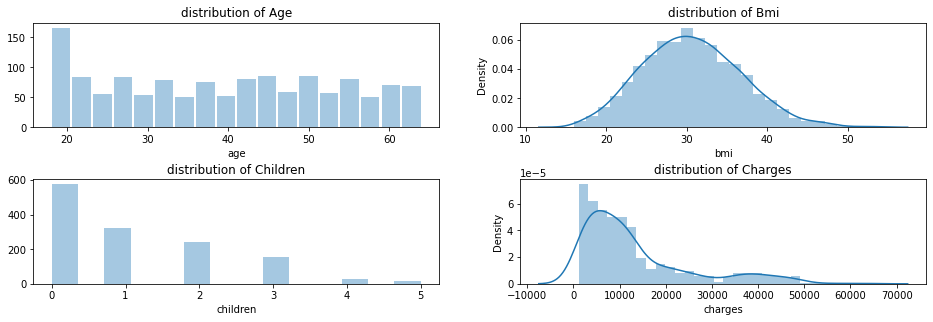

In [518]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(top=0.85, hspace=0.5)

plt.subplot(2,2,1)
plt.title('distribution of Age')
sns.distplot(df.age, kde=False,  hist_kws={'rwidth': 0.9}, bins=18);

plt.subplot(2,2,2)
plt.title('distribution of Bmi')
sns.distplot(df.bmi, kde=True);

plt.subplot(2,2,3)
plt.title('distribution of Children')
sns.distplot(df.children, kde=False);

plt.subplot(2,2,4)
plt.title('distribution of Charges')
sns.distplot(df.charges, kde=True);


In [519]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.000,39.207,14.050,18.000,27.000,39.000,51.000,64.000
bmi,1338.000,30.663,6.098,15.960,26.296,30.400,34.694,53.130
children,1338.000,1.095,1.205,0.000,0.000,1.000,2.000,5.000
charges,1338.000,13270.422,12110.011,1121.874,4740.287,9382.033,16639.913,63770.428


- Age özniteliği için yeni bir özellik eklenebilir çünkü üniform bir dağılım gösteriyor modelimiz sorun olabilir(yeni bir kategorik özellik eklenebilir)
- Charges özniteli sağa çarpık aykırı gözlemleri baskılayabiliriz ya da normalize edebiliriz
- BMI normal dağılım göstermiş

age        0.299
bmi        0.198
children   0.068
charges    1.000
Name: charges, dtype: float64


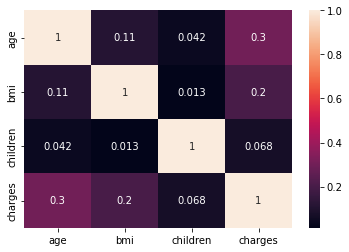

In [520]:
# Korelasyon incelemesi
sns.heatmap(df.corr(), annot=True)
print(df.corr()['charges'])

charges bizim hedef değişkenimiz bu yüzden diğer sayısal öznitelikler ile arasındaki korelasyona baktık. Age ve BMI ile düşük pozitif korelasyon var diyebiliriz. Bağımsız değişkenlerimiz arasında doğrusal bağlantı problemi yaratabilecek bir ilişki görünmüyor 

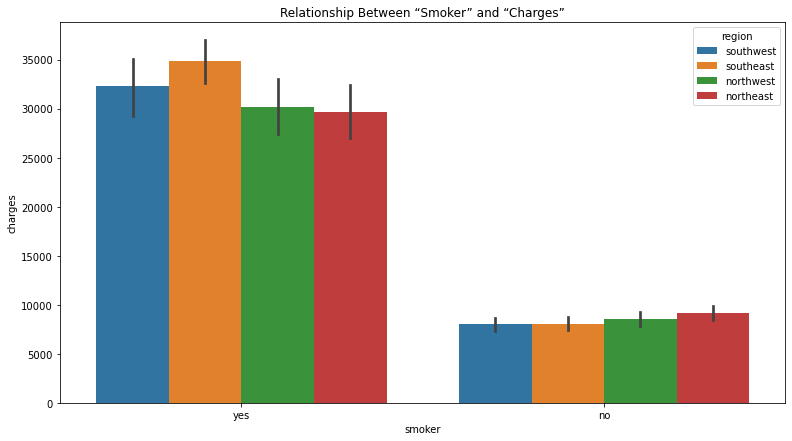

In [521]:
plt.figure(figsize=(13,7))
plt.title('Relationship Between “Smoker” and “Charges”')
sns.barplot(data=df, x=df['smoker'], y=df['charges'], hue='region');

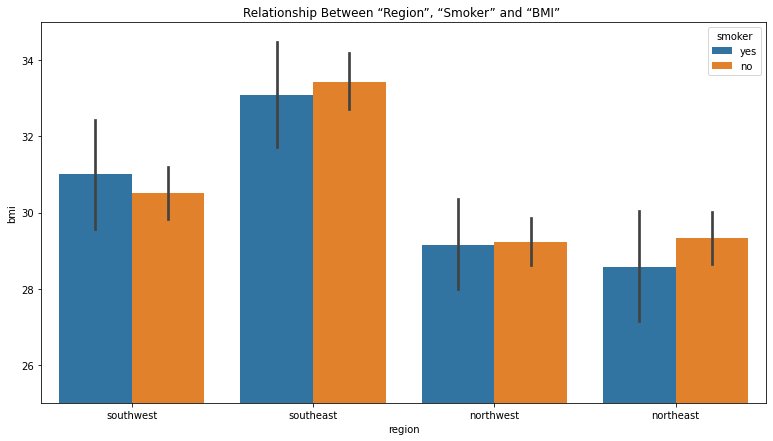

In [522]:
plt.figure(figsize=(13,7))
plt.title('Relationship Between “Region”, “Smoker” and “BMI” ')
sns.barplot(data=df, x=df['region'], y=df['bmi'], hue='smoker');
plt.ylim(25,35);


## Data Preprocessing

In [523]:
# age ve bmi değişkenlerinde yeni kategorik değişken çıkartma 
age_cat = ["0-18", "18-30", "30-45", "45-60", "60+"]

df["age_group"] = pd.cut(df["age"], bins=[0, 18, 30, 45, 60, 99], labels=age_cat, right=False)

bmi_cat = ['Underweight', 'Normal', 'Overweight', 'Obese (Class I)', 'Obese (Class II)',
           'Obese (Class III)']
df['bmi_group'] = pd.cut(df['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, 99], labels=bmi_cat, right=False)

# Kategorik değişkenlerin one-hot dönüşümü

df = pd.get_dummies(df,
                            columns=['sex','smoker','region', 'age_group','bmi_group'],
                            prefix=['sex','smoker','region', 'age_group','bmi_group'],
                            drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_18-30,age_group_30-45,age_group_45-60,age_group_60+,bmi_group_Normal,bmi_group_Overweight,bmi_group_Obese (Class I),bmi_group_Obese (Class II),bmi_group_Obese (Class III)
0,19,27.900,0,16884.924,0,1,0,0,1,1,0,0,0,0,1,0,0,0
1,18,33.770,1,1725.552,1,0,0,1,0,1,0,0,0,0,0,1,0,0
2,28,33.000,3,4449.462,1,0,0,1,0,1,0,0,0,0,0,1,0,0
3,33,22.705,0,21984.471,1,0,1,0,0,0,1,0,0,1,0,0,0,0
4,32,28.880,0,3866.855,1,0,1,0,0,0,1,0,0,0,1,0,0,0


In [568]:
# Veri setinin Eğitim ve Test olarak ayırıyoruz(test=0.2, eğitim=0.8)
y = df['charges']
X = df.drop(columns='charges', axis=1)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)


## Model Selection

In [569]:
# Çapraz doğrulama 
def crossval(model):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    forest_reg_rmse_scores = np.sqrt(-scores)
    return forest_reg_rmse_scores.mean()

# Model Başarı fonksiyonu
def basari(gercek, tahmin):
    rmse = mt.mean_squared_error(gercek,tahmin, squared=False)
    r2 = mt.r2_score(gercek, tahmin)
    return[rmse,r2]


In [570]:
# Linear regresyon
lr = LinearRegression()
linear_model = lr.fit(X_train,y_train)
linear_tahmin = linear_model.predict(X_test)

# Ridge Regresyon
ridge = Ridge()
ridge_model = ridge.fit(X_train, y_train)
ridge_tahmin = ridge_model.predict(X_test)

# Lasso Regresyon
lasso = Lasso()
lasso_model= lasso.fit(X_train, y_train)
lasso_tahmin = lasso_model.predict(X_test)

# ElasticNet Regresyon
elas = ElasticNet()
elas_model = elas.fit(X_train, y_train)
elas_tahmin = elas_model.predict(X_test)

# Decision Tree Regresyon
tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_model = tree_regressor.fit(X_train, y_train)
tree_tahmin = tree_model.predict(X_test)

# Random Forest Regresyon
random_for = RandomForestRegressor(random_state=42)
Forest_model = random_for.fit(X_train,y_train)
RandomForest_tahmin = Forest_model.predict(X_test)


In [572]:
results = [['Linear Model', basari(y_test,linear_tahmin)[0],basari(y_test,linear_tahmin)[1],crossval(linear_model)],
           ['Ridge Model', basari(y_test,ridge_tahmin)[0],basari(y_test,ridge_tahmin)[1],crossval(ridge_model)],
           ['Lasso Model', basari(y_test,lasso_tahmin)[0],basari(y_test,lasso_tahmin)[1],crossval(lasso_model)],
           ['ElasticNet Model', basari(y_test,elas_tahmin)[0],basari(y_test,elas_tahmin)[1],crossval(elas_model)],
           ['Random Forest Model', basari(y_test, RandomForest_tahmin)[0], basari(y_test,RandomForest_tahmin)[1], crossval(Forest_model)],
           ['Decision Tree Model', basari(y_test,tree_tahmin)[0],basari(y_test,tree_tahmin)[1],crossval(tree_model)]]
           
columns = ['Model', 'RMSE', 'R2', 'Doğrulama(cv)']

pd.set_option('display.float_format', '{:.3f}'.format)
results = pd.DataFrame(data=results,columns=columns)
results


,Model,RMSE,R2,Doğrulama(cv)
0,Linear Model,5795.377,0.784,6063.309
1,Ridge Model,5763.996,0.786,6065.861
2,Lasso Model,5783.119,0.785,6063.222
3,ElasticNet Model,9493.610,0.419,9440.048
4,Random Forest Model,4617.474,0.863,5011.246
5,Decision Tree Model,4776.261,0.853,4798.195


Modelimiz Random Forest olacak daha düşük bir rmse değeri aldık ve r2 skoruda baya yüksek. Şimdi Hiperparametre ayarını yapalım

## Hyper-parameter Optimization

In [555]:
# Random Forest için hiperparametre ayarı
forest_param_grid = [
    { "n_estimators": [10, 20, 30, 40, 50], "max_depth": [3, 5, 7, 9, 11] }, 
    { "bootstrap": [False], "n_estimators": [3, 10], "max_depth": [3, 5, 7, 9, 11]}
]
forest_reg = RandomForestRegressor(random_state=42)

forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, cv=5, scoring='neg_mean_squared_error', refit=True)
forest_grid_search.fit(X, y)
print("En iyi hiperparametre değerleri:", forest_grid_search.best_params_)

En iyi hiperparametre değerleri: {'max_depth': 5, 'n_estimators': 40}


In [573]:
random_for = RandomForestRegressor(random_state=42, max_depth=5,n_estimators = 40)
Forest_model = random_for.fit(X_train,y_train)
RandomForest_tahmin = Forest_model.predict(X_test)
final_basari= basari(y_test, RandomForest_tahmin)

## Model Evaluation

In [574]:
test_veriler = y_test
tahmin_veriler = RandomForest_tahmin
x_degerleri = np.arange(len(test_veriler))

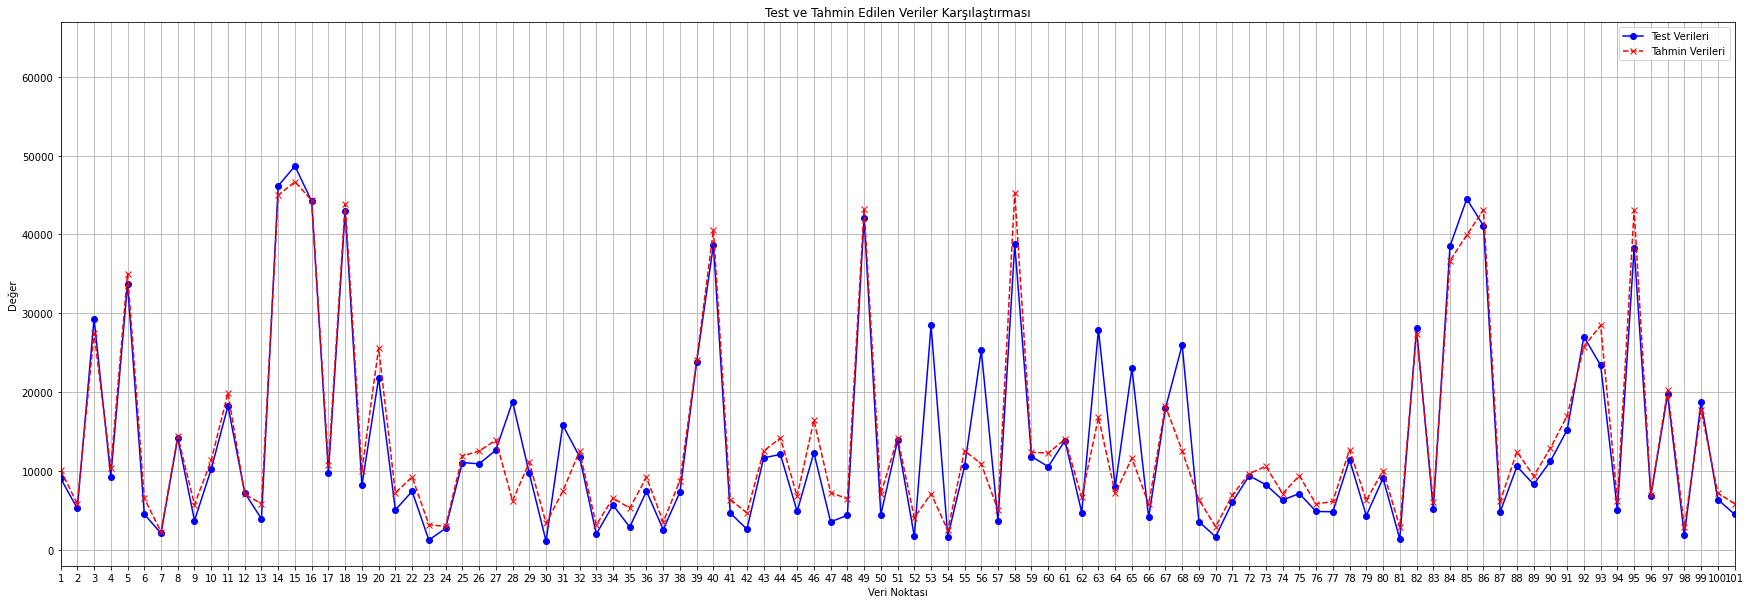

In [575]:
plt.figure(figsize=(30, 10))
plt.plot(x_degerleri, test_veriler, marker='o', color='blue', label='Test Verileri')
plt.plot(x_degerleri, tahmin_veriler, marker='x', color='red', linestyle='dashed', label='Tahmin Verileri')
plt.xticks(x_degerleri, x_degerleri + 1)  # x ekseni etiketleri
plt.xlabel('Veri Noktası')
plt.ylabel('Değer')
plt.title('Test ve Tahmin Edilen Veriler Karşılaştırması')
plt.xlim(0,100)
plt.legend()
plt.grid(True)
plt.show()

In [578]:
print(f'RMSE: {final_basari[0]}\nR2 Skor: {final_basari[1]}')

RMSE: 4436.725139959536
R2 Skor: 0.8732065004435026


Thank you for taking the time to explore my first Kaggle Notebook😊